In [1]:
%load_ext autoreload
%autoreload 2

Try with **multiple dimension**! 5 or 6

In [2]:
import warnings
warnings.filterwarnings("ignore")

from utils_artificial import gaussian_error_data
import pandas as pd

In [3]:
from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

# Error rate based on a gaussian

In [4]:
min_sups = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

In [6]:

n_attributes = 3
df_analysis, attributes, g, g_sc = gaussian_error_data(n = 10000, n_attributes = n_attributes)

from tqdm import tqdm 

from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)



pred_name ="predicted_class"
class_name =  "true_class" 
class_map = {"P":1, "N":0}

continuous_attributes = attributes

min_sup_divergence=0.025

type_experiment = "one_at_time"
metric = "d_error"
type_criterion = "divergence_criterion"


In [7]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()

stats_tree = {}
for min_support in min_sups:
    if min_support in stats_tree:
        continue
    print(min_support, end = " ")
    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analysis,
        type_splitting=type_experiment,
        min_support=min_support,
        metric=metric,
        continuous_attributes= list(continuous_attributes),
        storeTree=True,
        type_criterion = type_criterion,
        minimal_gain = 0.00,    
        class_map=class_map,
        class_and_pred_names=[class_name, pred_name],
    )    

    for apply_generalization in [True, False]:
        if apply_generalization is True:
            gen_type = "generalized"
        else:
            gen_type = "base"
        FP_fm = extract_divergence_generalized(
            df_analysis,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            true_class_name=pred_name,
            predicted_class_name=class_name,
            class_map=class_map,
            FPM_type="fpgrowth",
            metrics_divergence = [metric],
            type_experiment = type_experiment,
            allow_overalp = False if type_experiment!="all_attributes" else True
        )
        from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
        fp_divergence_o=FP_Divergence(FP_fm, metric)
        fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

        if min_support not in stats_tree:
            stats_tree[min_support] = {}
        stats_tree[min_support][gen_type] = fpdiv.iloc[0]
        

0.005 0.01 0.02 0.025 0.035 0.05 0.075 0.1 0.125 0.15 0.175 0.2 

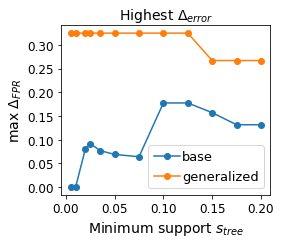

In [11]:
import matplotlib.pyplot as plt

show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]

n_attributes = 3
vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support: stats_tree[min_support]["base"]["d_error"] for min_support in stats_tree if min_support in show_sup}
gen =  { min_support: stats_tree[min_support]["generalized"]["d_error"] for min_support in stats_tree if min_support in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")
ax.set_title(r"Highest Δ$_{error}$")
ax.set_ylabel(r"max Δ$_{FPR}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
plt.legend( fontsize = 13, handletextpad=0.2)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
    item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)


plt.tight_layout();
plt.savefig(f"{outfig_dir}/artificial_gaussian_sensitivity_{n_attributes}_s_{min_sup_divergence}.pdf");